In [17]:
# Import external script
%run models.py

# Import libraries
from sklearn.model_selection import train_test_split as tts

# Import data from CSV
fdata = pd.read_csv('data_histories.csv', index_col="dp_folio")

pm = ProbModel()

In [19]:
# Clusterize between obese and non obese
obesity = {0:[1,2,3], 1:[4,5,6]}
ndata = pm.clusterize_discrete("AIMC", obesity, "obesity", fdata)

# Clusterize excercise features
ejer = {"A":"greatereq_than(2.5)", "B":"less_than(2.5)"}
ndata = pm.clusterize_continuous("ejer_act", ejer, "ejer0B", ndata)
ndata = pm.clusterize_continuous("ejer1", ejer, "ejer1B", ndata)
ndata = pm.clusterize_continuous("ejer5", ejer, "ejer5B", ndata)
ndata = pm.clusterize_continuous("ejer10", ejer, "ejer10B", ndata)
ndata = pm.clusterize_continuous("ejer20", ejer, "ejer20B", ndata)
ndata = pm.clusterize_continuous("ejer30", ejer, "ejer30B", ndata)

ndata = pm.group_list_of_variables(["ejer0B", "ejer1B"], "ejer0_1", ndata)
ndata = pm.group_list_of_variables(["ejer0B", "ejer1B", "ejer5B"], "ejer0_5", ndata)
ndata = pm.group_list_of_variables(["ejer0B", "ejer1B", "ejer5B", "ejer10B"], "ejer0_10", ndata)
ndata = pm.group_list_of_variables(["ejer0B", "ejer1B", "ejer5B", "ejer10B", "ejer20B"], "ejer0_20", ndata)

In [20]:
# Select relevant data
selected_class = "obesity"
filtered_features = ["ejer0B", "ejer1B", "ejer5B", "ejer10B", "ejer20B", "ejer0_1", "ejer0_5", "ejer0_10", "ejer0_20"]
sdata = ndata[filtered_features].join(ndata[selected_class])
sdata = sdata[(sdata.ejer20B != "N") & (sdata.ejer10B != "N") & (sdata.ejer5B != "N") & (sdata.ejer1B != "N") & (sdata.ejer0B != "N")]
sdata

,ejer0B,ejer1B,ejer5B,ejer10B,ejer20B,ejer0_1,ejer0_5,ejer0_10,ejer0_20,obesity
dp_folio,,,,,,,,,,
1,B,B,B,B,B,BB,BBB,BBBB,BBBBB,1
2,B,B,A,A,A,BB,BBA,BBAA,BBAAA,0
4,B,B,A,A,A,BB,BBA,BBAA,BBAAA,1
5,B,B,B,B,B,BB,BBB,BBBB,BBBBB,0
6,A,B,B,B,B,AB,ABB,ABBB,ABBBB,0
...,...,...,...,...,...,...,...,...,...,...
1076,B,B,B,A,A,BB,BBB,BBBA,BBBAA,1
1077,A,A,B,B,B,AA,AAB,AABB,AABBB,0
1078,B,A,A,A,A,BA,BAA,BAAA,BAAAA,0


In [25]:
# Split the data between training and test (2/3 for training and 1/3 for testing)
X = sdata[filtered_features]
Y = sdata[selected_class]
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.333)

print(X_train.shape)
print(X_test.shape)
data_train = X_train.join(Y_train)
data_test = X_test.join(Y_test)
data_train.head()

(626, 9)
(313, 9)


,ejer0B,ejer1B,ejer5B,ejer10B,ejer20B,ejer0_1,ejer0_5,ejer0_10,ejer0_20,obesity
dp_folio,,,,,,,,,,
744,A,B,B,B,A,AB,ABB,ABBB,ABBBA,0
95,B,B,B,B,B,BB,BBB,BBBB,BBBBB,0
580,B,B,A,A,A,BB,BBA,BBAA,BBAAA,1
800,B,B,B,A,B,BB,BBB,BBBA,BBBAB,0
824,A,B,B,A,A,AB,ABB,ABBA,ABBAA,0


In [28]:
# Create a classifier object
nb = NB()

In [40]:
queries = {
    "ejer0B": ["A", "B"],
    "ejer1B": ["A", "B"],
    "ejer5B": ["A", "B"],
    "ejer10B": ["A", "B"],
    "ejer20B": ["A", "B"],
    "ejer0_1": np.array(pm.string_generator("", ["A", "B"], 2)).flatten(),
    "ejer0_5": np.array(pm.string_generator("", ["A", "B"], 3)).flatten(),
    "ejer0_10": np.array(pm.string_generator("", ["A", "B"], 4)).flatten(),
    "ejer0_20": np.array(pm.string_generator("", ["A", "B"], 5)).flatten()
}

In [41]:
nb.get_score_full("ejer0_20", "A****", "obesity", 1, sdata)

{'feat': 'ejer0_20',
 'cat': 'A****',
 'class': 'obesity',
 'classcat': 1,
 'score': -0.5821686725978958,
 'nx': 361,
 'ncx': 50,
 'nc': 213}

In [37]:
scores_breakdown = nb.get_scores_from_featlist_and_catlist_full(queries, selected_class, 1, sdata)

In [42]:
scores_breakdown.to_csv("scores_breakdown.csv")

## Incremental information model comparison

In [70]:
nb1 = NB()
query_features_nb1 = {
    "ejer0B": ["A", "B"]
}
nb1.train(query_features_nb1, "obesity", 1, data_train)
nb1.predict(data_test)

In [61]:
nb2 = NB()
query_features_nb2 = {
    "ejer0_1": np.array(pm.string_generator("", ["A", "B"], 2)).flatten()
}
nb2.train(query_features_nb2, "obesity", 1, data_train)
nb2.predict(data_test)

In [55]:
nb3 = NB()
query_features_nb3 = {
    "ejer0_5": np.array(pm.string_generator("", ["A", "B"], 3)).flatten()
}
nb3.train(query_features_nb3, "obesity", 1, data_train)
nb3.predict(data_test)

In [56]:
nb4 = NB()
query_features_nb4 = {
    "ejer0_10": np.array(pm.string_generator("", ["A", "B"], 4)).flatten()
}
nb4.train(query_features_nb4, "obesity", 1, data_train)
nb4.predict(data_test)

In [57]:
nb5 = NB()
query_features_nb5 = {
    "ejer0_20": np.array(pm.string_generator("", ["A", "B"], 5)).flatten()
}
nb5.train(query_features_nb5, "obesity", 1, data_train)
nb5.predict(data_test)

In [75]:
nba = NB()
query_features_nba = {
    "ejer0B": ["A", "B"],
    "ejer1B": ["A", "B"],
    "ejer5B": ["A", "B"],
    "ejer10B": ["A", "B"],
    "ejer20B": ["A", "B"]    
}
nba.train(query_features_nba, "obesity", 1, data_train)
nba.predict(data_test)

In [110]:
prednb1 = nb1.predicted_scores[["ejer0B"]]
prednba = nba.predicted_scores[["ejer1B", "ejer5B", "ejer10B", "ejer20B"]]
prednb2 = nb2.predicted_scores[["ejer0_1"]]
prednb3 = nb3.predicted_scores[["ejer0_5"]]
prednb4 = nb4.predicted_scores[["ejer0_10"]]
prednb5 = nb5.predicted_scores[["ejer0_20"]]

preds = prednb1.join(prednba).join(prednb2).join(prednb3).join(prednb4).join(prednb5)
data_test.join(preds, rsuffix="_score").to_csv("scores_breakdown_models.csv")

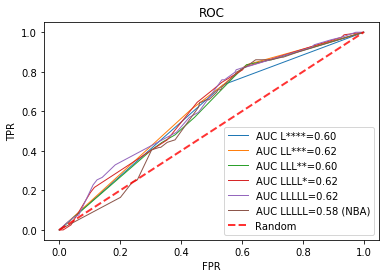

In [84]:
# Predict
Y_prob1 = nb1.get_predicted_scores()
fpr1, tpr1, thresholds = roc_curve(data_test["obesity"].values, Y_prob1.values[:, -1])
roc_auc1 = auc(fpr1, tpr1)

Y_prob2 = nb2.get_predicted_scores()
fpr2, tpr2, thresholds = roc_curve(data_test["obesity"].values, Y_prob2.values[:, -1])
roc_auc2 = auc(fpr2, tpr2)

Y_prob3 = nb3.get_predicted_scores()
fpr3, tpr3, thresholds = roc_curve(data_test["obesity"].values, Y_prob3.values[:, -1])
roc_auc3 = auc(fpr3, tpr3)

Y_prob4 = nb4.get_predicted_scores()
fpr4, tpr4, thresholds = roc_curve(data_test["obesity"].values, Y_prob4.values[:, -1])
roc_auc4 = auc(fpr4, tpr4)

Y_prob5 = nb5.get_predicted_scores()
fpr5, tpr5, thresholds = roc_curve(data_test["obesity"].values, Y_prob5.values[:, -1])
roc_auc5 = auc(fpr5, tpr5)

Y_proba = nba.get_predicted_scores()
fpra, tpra, thresholds = roc_curve(data_test["obesity"].values, Y_proba.values[:, -1])
roc_auca = auc(fpra, tpra)

plt.plot(fpr1, tpr1, lw=1, alpha=1.0, label="AUC L****=%0.2f" % (roc_auc1))
plt.plot(fpr2, tpr2, lw=1, alpha=1.0, label="AUC LL***=%0.2f" % (roc_auc2))
plt.plot(fpr3, tpr3, lw=1, alpha=1.0, label="AUC LLL**=%0.2f" % (roc_auc3))
plt.plot(fpr4, tpr4, lw=1, alpha=1.0, label="AUC LLLL*=%0.2f" % (roc_auc4))
plt.plot(fpr5, tpr5, lw=1, alpha=1.0, label="AUC LLLLL=%0.2f" % (roc_auc5))
plt.plot(fpra, tpra, lw=1, alpha=1.0, label="AUC LLLLL=%0.2f (NBA)" % (roc_auca))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random', alpha=.8)
plt.legend(loc="lower right")
plt.show()